# Introduction

This project will use a convolutional neural network (CNN) to detect and recognize the type of animal that appears in images. The dataset has images on 10 animals: dog, horse, elephant, sheep, cat, squirrel, chicken, spider, cow, and butterfly. Each image contains only one of the specificed animal categories. So in each image, there can be one single animal, multiple of the same animal, or multiple different animals, as long as only one of the animals is a specified category. For example, If an image has a cow and a pig in it, it should be categorized as cow. 


# The Data
The data comes from Kaggle. The dataset includes ~26,000 images, split into 10 classes. The images are not the same size, but all are RGB. There is not specific training, validation, and test sets so we will create our own. The images are split into folders, one for each class/animal. There is not an equal number of images per animal. The description states that there is some erroneous data to simulate real life conditions. So some of the labels in the dataset are incorrect. 

Here is the link to data on Kaggle: https://www.kaggle.com/datasets/alessiocorrado99/animals10

We will look more into the data below:

# Exploratory Data Analysis

In [100]:
#import all necessary libraries
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil
from collections import Counter
#from tqdm import tqdm_notebook,trange
import tqdm

from PIL import Image
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import vgg16, resnet

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
#Check to confirm the data files are there
print(os.listdir("../input/animals10/"))

#set file path variables
train_path = '/kaggle/input/animals10/raw-img'

['translate.py', 'raw-img']


In [3]:
#check the number of files
file_count = 0
#go through the file path
for root, dirs, files in os.walk(train_path):
    file_count += len(files)
    
print('The number of training samples: ', file_count)    

The number of training samples:  26179


In [4]:
#make dictionary to translate from the latin word to english
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider",
             "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante",
             "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca",
             "spider": "ragno", "squirrel": "scoiattolo"}

In [5]:
#put all image filepaths into dataframe
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*/*.*'))})
#make id column for use in imagegenerator
df['id'] = df.path.map(lambda x: '/'.join(x.split('/')[5:]))

#make label column from the folder name
df['label'] = df.path.map(lambda x: translate[x.split('/')[5].split(".")[0]])

#get len of df
N = len(df)
df

path  \
0      /kaggle/input/animals10/raw-img/cavallo/OIP-md...   
1      /kaggle/input/animals10/raw-img/cavallo/OIP-TP...   
2      /kaggle/input/animals10/raw-img/cavallo/OIP-jl...   
3      /kaggle/input/animals10/raw-img/cavallo/OIP-F4...   
4      /kaggle/input/animals10/raw-img/cavallo/OIP-UF...   
...                                                  ...   
26174  /kaggle/input/animals10/raw-img/farfalla/OIP-4...   
26175  /kaggle/input/animals10/raw-img/farfalla/OIP-Q...   
26176  /kaggle/input/animals10/raw-img/farfalla/OIP-1...   
26177  /kaggle/input/animals10/raw-img/farfalla/eb32b...   
26178  /kaggle/input/animals10/raw-img/farfalla/ea36b...   

                                                      id      label  
0            cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg      horse  
1            cavallo/OIP-TPYKs3XId_sMgp_6LLA6JgDMEy.jpeg      horse  
2            cavallo/OIP-jlVRrokx7Vu1axi8OnTX2AHaE2.jpeg      horse  
3            cavallo/OIP-F4QVZ71QagiynDMnFNxJUAHaEK.jpeg      horse  
4            cavallo/OIP-UFtUZnXq0JHZo5R8UuF80wHaFj.jpeg      horse  
...                                                  ...        ...  
26174       farfalla/OIP-4P7_7D5HO1WvKvQj9dL8kAHaFj.jpeg  butterfly  
26175       farfalla/OIP-QeS6A53er7mIZonWQJCDFgHaGr.jpeg  butterfly  
26176       farfalla/OIP-1fQ1-C2hmEL5tEkMwORpawHaHa.jpeg  butterfly  
26177  farfalla/eb32b60920f6063ed1584d05fb1d4e9fe777e...  butterfly  
26178  farfalla/ea36b20c29fc003ed1584d05fb1d4e9fe777e...  butterfly  

[26179 rows x 3 columns]

In [6]:
#sample 10 random images and print out their image size
indxs = np.random.randint(0,N,10)
for i,idx in enumerate(indxs):
    filepath = df.loc[idx,'path']
    img = cv2.imread(filepath, cv2.IMREAD_ANYCOLOR)
    print("The shape of random image "+ str(i+1) + " is: ", img.shape)

The shape of random image 1 is:  (140, 300, 3)
The shape of random image 2 is:  (136, 300, 3)
The shape of random image 3 is:  (225, 300, 3)
The shape of random image 4 is:  (300, 239, 3)
The shape of random image 5 is:  (225, 300, 3)
The shape of random image 6 is:  (216, 288, 3)
The shape of random image 7 is:  (300, 298, 3)
The shape of random image 8 is:  (300, 300, 3)
The shape of random image 9 is:  (300, 200, 3)
The shape of random image 10 is:  (226, 300, 3)


There are 26,179 images in the dataset. The images are different sizes. We will need to resize the images to the same size to feed into our models. 

We will now look at 20 random example photos from the dataset:

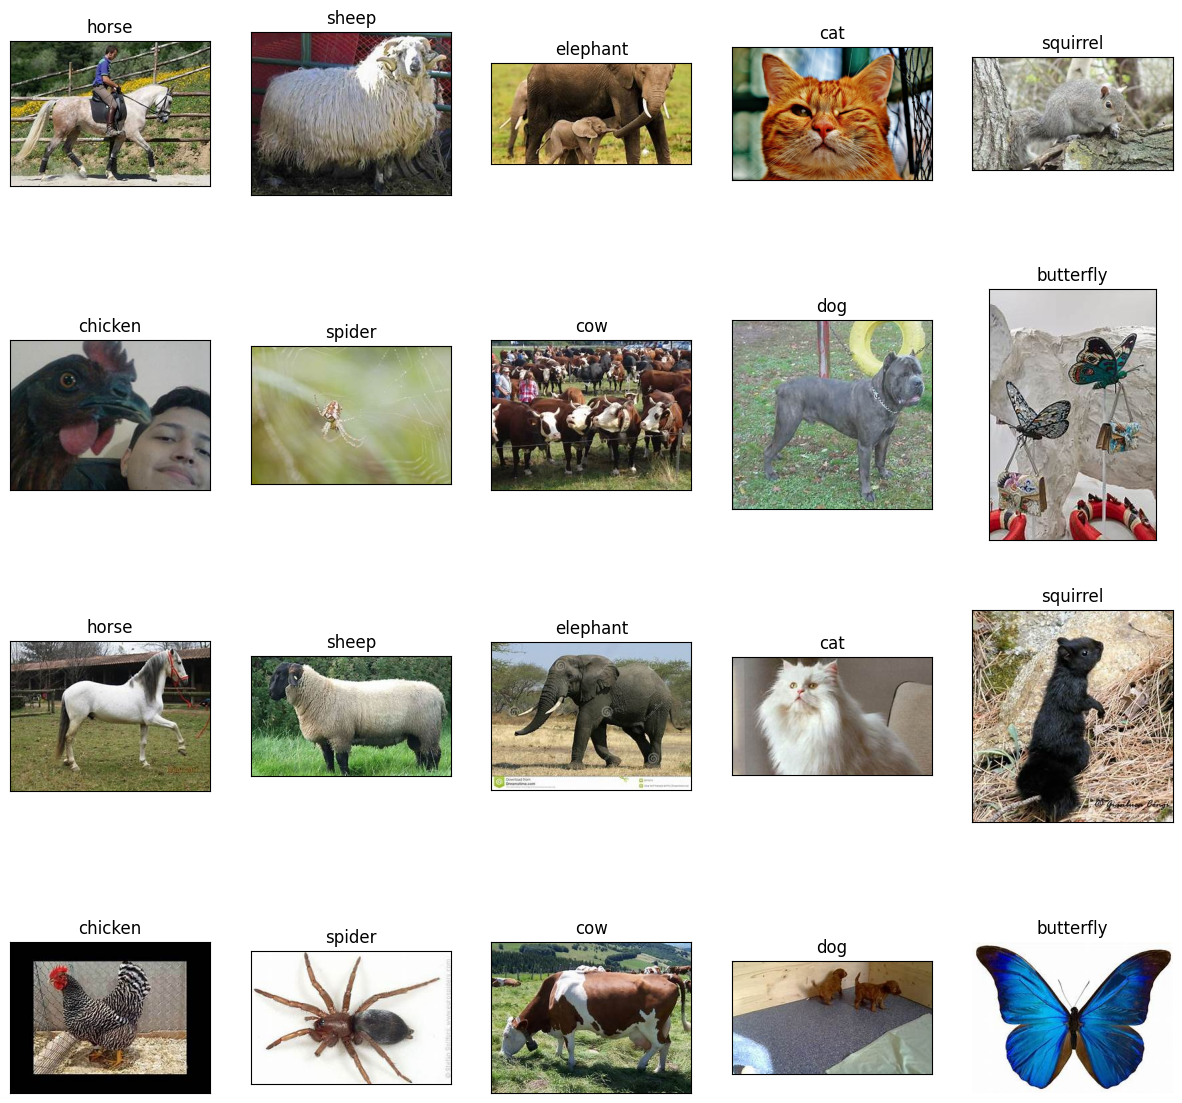

In [7]:
#get all the unique animal classes
animals = df['label'].unique()
#randomly sample 20 numbers
randsamp = np.random.randint(0,1000,20)
#make a subplot
fig, axs = plt.subplots(4, 5, figsize=(15,15))
#iterate of subplots
for i, ax in enumerate(fig.axes):
    #if the i is greater than 9, need to subtract 10
    #to get back to beginning of animals list
    if i > 9:
        j = i - 10
    else:
        j = i
    
    #get image path
    img_path = list(df[df['label'] == animals[j]].loc[:,'path'])[randsamp[i]]
    #open image
    img = Image.open(img_path)
    #show image
    ax.imshow(img)
    #turn off axis
    plt.axis('off')
    #make the title 0 for no tumor, or 1 for tumer
    ax.set_title(list(df[df['label'] == animals[j]].loc[:,'label'])[randsamp[i]])
    #remove tick marks
    ax.set(xticks=[], yticks=[])   

The above images give a sample of images in the data set. We can clearly see that the images are different sizes. Some of the images have multiple of the specified animal, and one photo has a human with a chicken (but a human is not a class in this dataset so should be labeled chicken).

We will look into the counts of each label, and then we will look at the pixel distribution of the images to see if we can gain any insights. 

The histogram below shows the quantity of each label. The groups are unbalanced. We may need to look at this further. If our results show that the model predicts dog and spider more than it should, it could be because of the unbalanced dataset. 

Text(0, 0.5, 'Frequency')

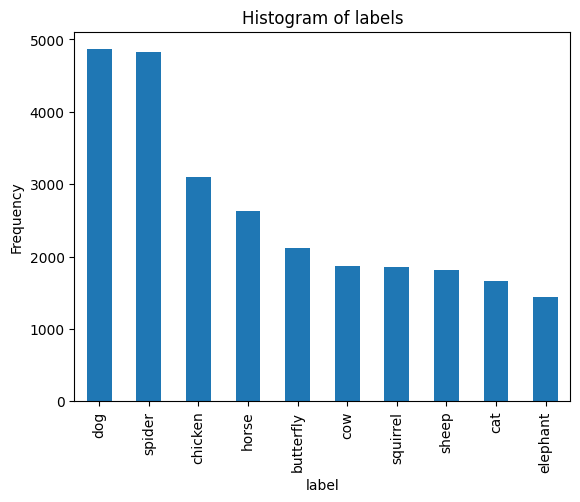

In [8]:
#make histogram of labels
df['label'].value_counts().plot(kind='bar',rot=90)
plt.title("Histogram of labels")
plt.ylabel('Frequency')

In [9]:
#this cell block is to put all image pixel values into a numpy array to then
#analyze the pixel value distributions
#set how often you want a printout of images gone through
check = 2500

#allocate a numpy array for the images (N, 224x224px, 3 channels, values 0 - 255)
#we have to resize our images to 224x224
X = np.zeros([N,224,224,3],dtype=np.uint8) 
#convert the labels to a numpy array
y = np.array(df['label'])

#read images one by one
for i, row in df.iterrows():
    #if remainder is 0, print the number of images gone through
    if i % check == 0:
        print(i)
    #read in image
    img = cv2.imread(row['path'])
    #resize to 224x224 and store in X
    X[i] = cv2.resize(img, (224, 224))

0
2500


libpng warning: iCCP: known incorrect sRGB profile


5000
7500
10000
12500
15000
17500
20000
22500


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


25000


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [10]:
#make df for specific classes
horse_samples = X[y == 'horse']
#len(horse_samples)
butterfly_samples = X[y == 'butterfly']
sheep_samples = X[y == 'sheep']

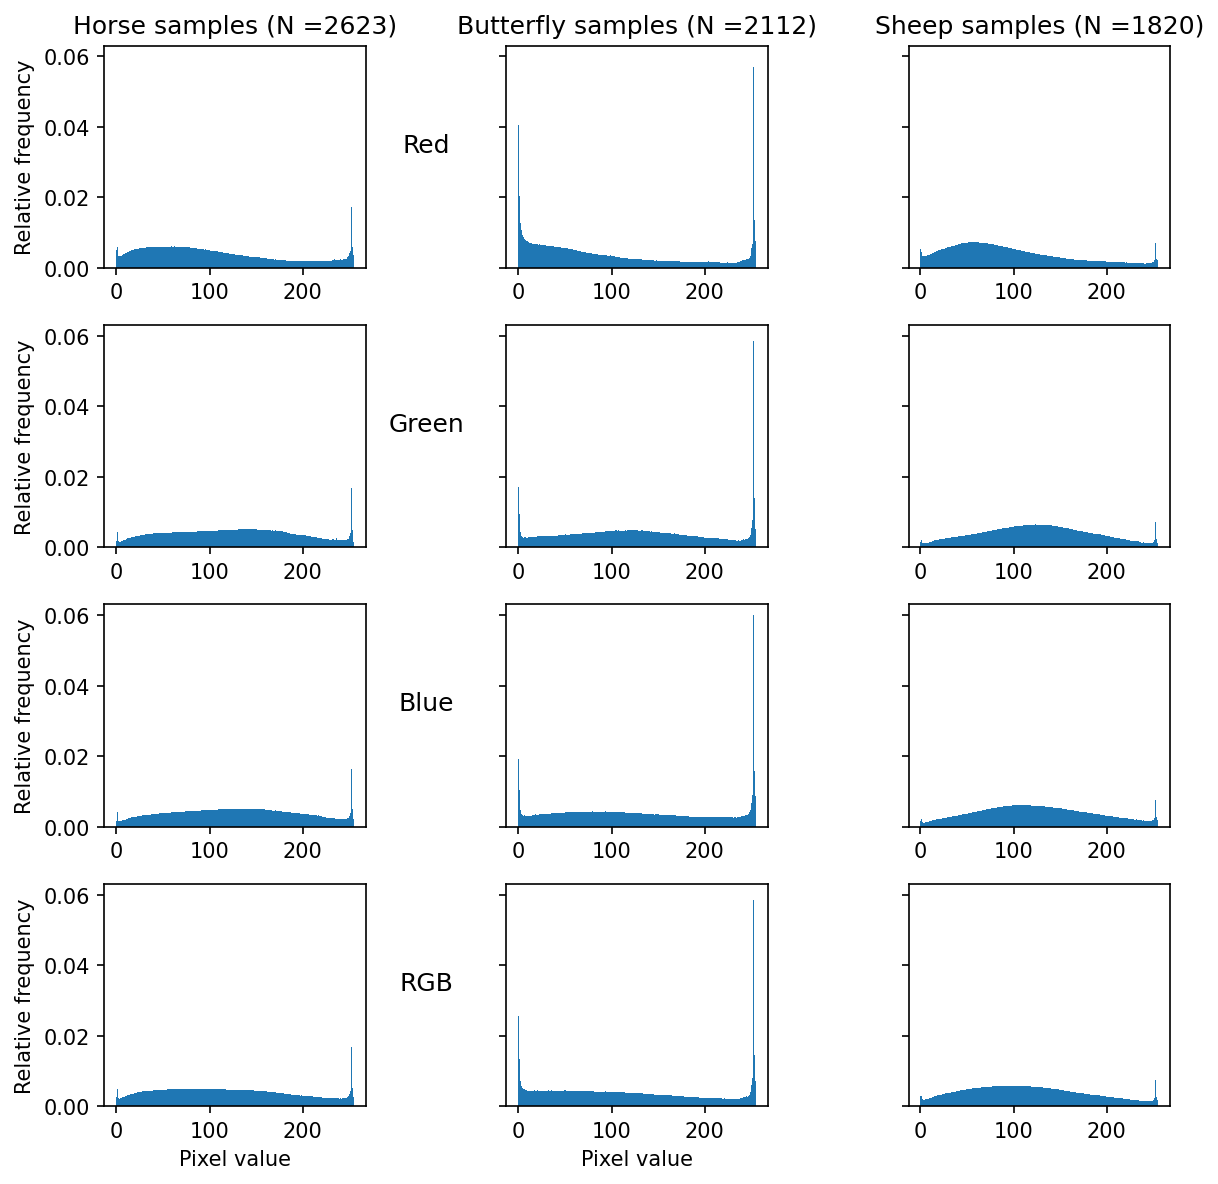

In [11]:
#We will set bins to 256 so each pixel value gets a bin
nr_of_bins = 256 
#make subplots
fig,axs = plt.subplots(4,3,sharey=True,figsize=(8,8),dpi=150)

#Make a histogram for each of Red, Green, and Blue pixel values for
#horse, butterfly, and sheep images
axs[0,0].hist(horse_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(butterfly_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,2].hist(sheep_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(horse_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(butterfly_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,2].hist(sheep_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(horse_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(butterfly_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,2].hist(sheep_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#Make histogram of combined RGB pixel values for those 3 classes
axs[3,0].hist(horse_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(butterfly_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,2].hist(sheep_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Horse samples (N =" + str(horse_samples.shape[0]) + ")");
axs[0,1].set_title("Butterfly samples (N =" + str(butterfly_samples.shape[0]) + ")");
axs[0,2].set_title("Sheep samples (N =" + str(sheep_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

Text(0, 0.5, 'Relative frequency')

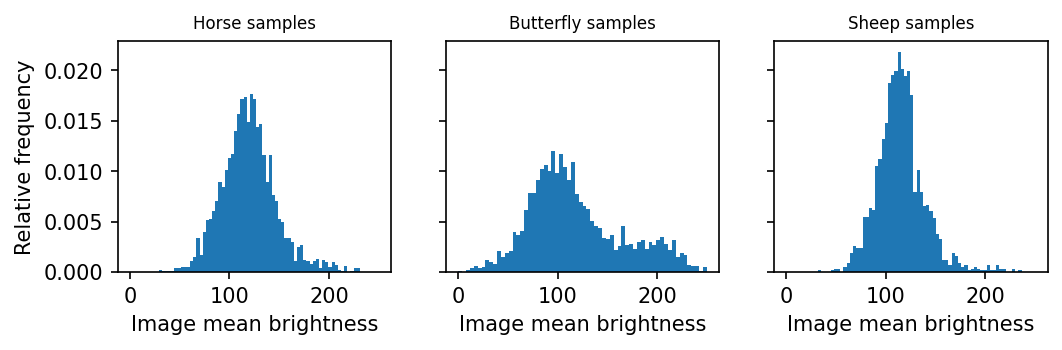

In [12]:
nr_of_bins = 64
#make subplots
fig,axs = plt.subplots(1,3,sharey=True, sharex = True,figsize=(8,2),dpi=150)

#make histogram for the mean pixel value for the 3 specified classes
axs[0].hist(np.mean(horse_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(butterfly_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[2].hist(np.mean(sheep_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);

#set title and labels
axs[0].set_title("Horse samples",fontsize=8);
axs[1].set_title("Butterfly samples",fontsize=8);
axs[2].set_title("Sheep samples",fontsize=8);
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[2].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")

From the first set of histograms, it looks like sheep is more closely centered around 100 for the 3 color values. The butterfly images have much more pixels at the very top range (~255). All 3 classes seem to have lower pixel values for red, higher for green, and more central for blue. 

The average pixel value per image histogram shows the butterfly has many more ~200, and sheep is much more closely centered (a little over 100). 


# Plan of Analysis
We will load the images into a datset using Keras. We will split the data set to 0.8 training and 0.2 testing. Then we will split the training again to 0.8 training and 0.2 validation. During this stage there are many different preprocessing steps we could utilize on our images. Initially, we will resize the images to a consistent size and normalize the inputs to make all input between 0 and 1. We will normalize by dividing the inputs by 255, since all the RGB values are on a scale from 0 to 255. This is an important step for neural networks to ensure that a single input doesn't have an outsized impact on the result. These are the only preprocessing steps we will perform for the first model. We may trial additional preprocessing steps in a later step. 

This will then be the input to our CNN. We will construct multiple CNN structures and see what worked the best. 

The CNN structures we will trial:

1. Base model: A basic structure with 3 convultional layers, then a maxpool, followed by the classifier. The convulational layers will have a stride of 2 to reduce the number of parameters:
* conv x3 -> maxpool -> classifier

2. Extended and tuned model: Similar to number 1, but repeating the convultional layers and maxpool layers three times with batch normalization and dropout. The convulational layers will have a stride of 1, and then the classifier at the end:
* [conv and batchnormalization x3 -> maxpool -> dropout]x3 -> classifier


3. VGG16 model with pre-trained weights, standard preprocessing: The third model will be one from keras.applications. We will use VGG16 with the pre-trained weights from ImageNet. We will use the standard preprocessing steps that were used on the first two models. We will add a similar classifier to the end as the previous two. 

4. VGG16 model with pre-trained weight, VGG16 preprocessing: similar to model 3, but has VGG16 preprocessing instead of our standard preprocessing.

The first model will not tune any hyperparameters. The second model has some hyperparemeters tuned, and the third is set up as used in the keras.applications. All models will use a "softmax" activation at the end because the result is a classification problem between 10 classes. 

We will be passing the models resized images of 224x224 pixels. We are using 224x224 because this is the size required to use the model with pre-trained weights and we want to be able to compare our different options. 

I believe the models will perform in the order of their complexity: the VGG16 models will be best, then the extended model, and the base model will perform worst. I think the VGG16 model using VGG16 preprocessing will perform the best because it will allow the images to be preprocessed in the same way as the training images were. 

# Load data with Keras

In [13]:
#split into train and test set
df_train, df_test = train_test_split(df, test_size=0.2)

In [14]:
df_train

path  \
8947   /kaggle/input/animals10/raw-img/scoiattolo/OIP...   
25544  /kaggle/input/animals10/raw-img/farfalla/OIP-M...   
2590   /kaggle/input/animals10/raw-img/cavallo/OIP-hn...   
9483   /kaggle/input/animals10/raw-img/gallina/OIP-mF...   
21386  /kaggle/input/animals10/raw-img/cane/OIP-pvLK0...   
...                                                  ...   
23547  /kaggle/input/animals10/raw-img/cane/OIP-5lIEi...   
22141  /kaggle/input/animals10/raw-img/cane/OIP-PpxmR...   
12225  /kaggle/input/animals10/raw-img/gallina/OIP-Dz...   
12324  /kaggle/input/animals10/raw-img/gallina/OIP-IK...   
15472  /kaggle/input/animals10/raw-img/ragno/OIP-zPWd...   

                                                   id      label  
8947   scoiattolo/OIP-JNMiG-coWvCBi7lpuOcKxQHaLG.jpeg   squirrel  
25544    farfalla/OIP-MWgVYikyKMtat0l5J-gG8QHaFj.jpeg  butterfly  
2590      cavallo/OIP-hnLlh9RxFZlzJW3JJNVJPwHaFs.jpeg      horse  
9483      gallina/OIP-mFN57MsrJHRtpCcbq51anQHaCh.jpeg    chicken  
21386        cane/OIP-pvLK0Qm58FVMLYeD94Xl0QHaJQ.jpeg        dog  
...                                               ...        ...  
23547        cane/OIP-5lIEik8XqUSN8ebH6XUslAHaH5.jpeg        dog  
22141        cane/OIP-PpxmRKqgTxIGYn1rq8MdxAHaGG.jpeg        dog  
12225     gallina/OIP-Dz4RELcVx-Ri4qg6eVtbfAHaFj.jpeg    chicken  
12324     gallina/OIP-IKADaNNJSxZVDcHnLHfsbAHaFb.jpeg    chicken  
15472       ragno/OIP-zPWdlcEcEU3uu4q28z37UQHaFA.jpeg     spider  

[20943 rows x 3 columns]

In [15]:
df_test

path  \
21064  /kaggle/input/animals10/raw-img/cane/OIP-DKmEn...   
3515   /kaggle/input/animals10/raw-img/pecora/OIP-AKL...   
24716  /kaggle/input/animals10/raw-img/farfalla/OIP-E...   
25716  /kaggle/input/animals10/raw-img/farfalla/OIP-c...   
2695   /kaggle/input/animals10/raw-img/pecora/OIP-rcy...   
...                                                  ...   
14228  /kaggle/input/animals10/raw-img/ragno/OIP-_0YC...   
21781  /kaggle/input/animals10/raw-img/cane/OIP-MXyip...   
1994   /kaggle/input/animals10/raw-img/cavallo/OIP-Y7...   
19506  /kaggle/input/animals10/raw-img/cane/OIP-7_b6B...   
20751  /kaggle/input/animals10/raw-img/cane/OIP-aUFx6...   

                                                 id      label  
21064      cane/OIP-DKmEnHHux5z1gNZQMm7rhgHaFj.jpeg        dog  
3515     pecora/OIP-AKLnkpH6ds9Z8nweYcj3PQHaBv.jpeg      sheep  
24716  farfalla/OIP-EWTqZHZPtPVEfBnMDFTZngHaEK.jpeg  butterfly  
25716  farfalla/OIP-cgVnkaB7_2hEJ-7lhGelNgHaFj.jpeg  butterfly  
2695     pecora/OIP-rcyqXob3zEHEfkKDA-p5RwAAAA.jpeg      sheep  
...                                             ...        ...  
14228     ragno/OIP-_0YC0pbR0XIolgpTaswWRwHaFj.jpeg     spider  
21781      cane/OIP-MXyipK6U0Jit6RIMB1Gs8gAAAA.jpeg        dog  
1994    cavallo/OIP-Y7KyhD1odFEC5rJ8zPMJHgHaEI.jpeg      horse  
19506      cane/OIP-7_b6BO01yoDYJIA1NQIkPQHaFf.jpeg        dog  
20751      cane/OIP-aUFx6UG7auu2yrLxURcFSQHaF0.jpeg        dog  

[5236 rows x 3 columns]

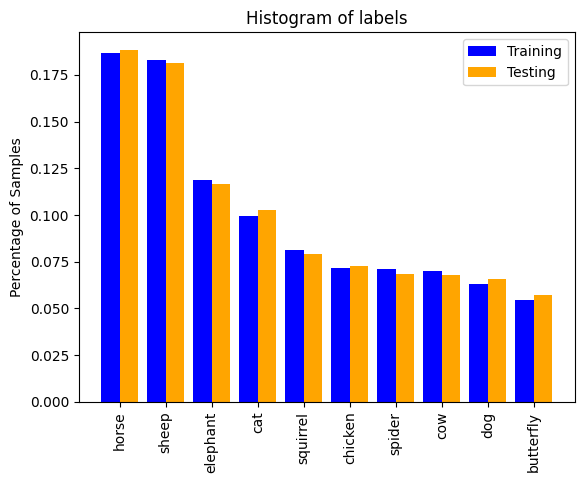

In [16]:
#get the quantity per label in each dataset
class_counter_train = df_train['label'].value_counts()
class_counter_test = df_test['label'].value_counts()

#make the quantity to a percentage
class_percent_train = class_counter_train/len(df_train)
class_percent_test = class_counter_test/len(df_test)

#make plot
fig, ax1 = plt.subplots()

#make x-axis
X_axis = np.arange(len(animals))

#set colors
color_train = 'b'
color_test = 'orange'
#make bar plot of training data
ax1.bar(X_axis-0.2, class_percent_train,0.4, color = color_train, label = "Training")
ax1.set_ylabel("Percentage of Samples", fontsize=10)
#make bar plot of test data
ax1.bar(X_axis+0.2, class_percent_test,0.4 , color = color_test,label = "Testing")

#set ticke marks and legend and title
plt.xticks(X_axis, animals)
ax1.tick_params(axis = 'x', rotation = 90)
plt.title("Histogram of labels")
plt.legend()
plt.show()

In [79]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

#define parameters for keras function
batch_size = 32
#want 224x224 for pre-trained models
img_size = 224 

#set a seed for reproductibility
rnd_seed = 176

In [82]:
# generate training data
train_data = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="categorical",
    target_size=(img_size,img_size),
    subset='training')

Found 16755 validated image filenames belonging to 10 classes.


In [83]:
# generate validation data
val_data = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="categorical",
    target_size=(img_size,img_size),
    subset='validation')

Found 4188 validated image filenames belonging to 10 classes.


In [84]:
#genrate test data that is not shuffled 
#for the model to use to make predictions on
datagen2 = ImageDataGenerator(rescale=1./255.)
test_data = datagen2.flow_from_dataframe(
    dataframe=df_test,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="categorical",
    target_size=(img_size,img_size),
    shuffle=False)

Found 5236 validated image filenames belonging to 10 classes.


In [23]:
#get class indices and reverse dictionary so can use later
train_data.class_indices
reverse_class_ind = {num: let for let, num in train_data.class_indices.items()}
eng_reverse_class = {}
for i in range(len(reverse_class_ind)):
    eng_reverse_class[i] =  reverse_class_ind[i]
    
eng_reverse_class

{0: 'butterfly',
 1: 'cat',
 2: 'chicken',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'horse',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

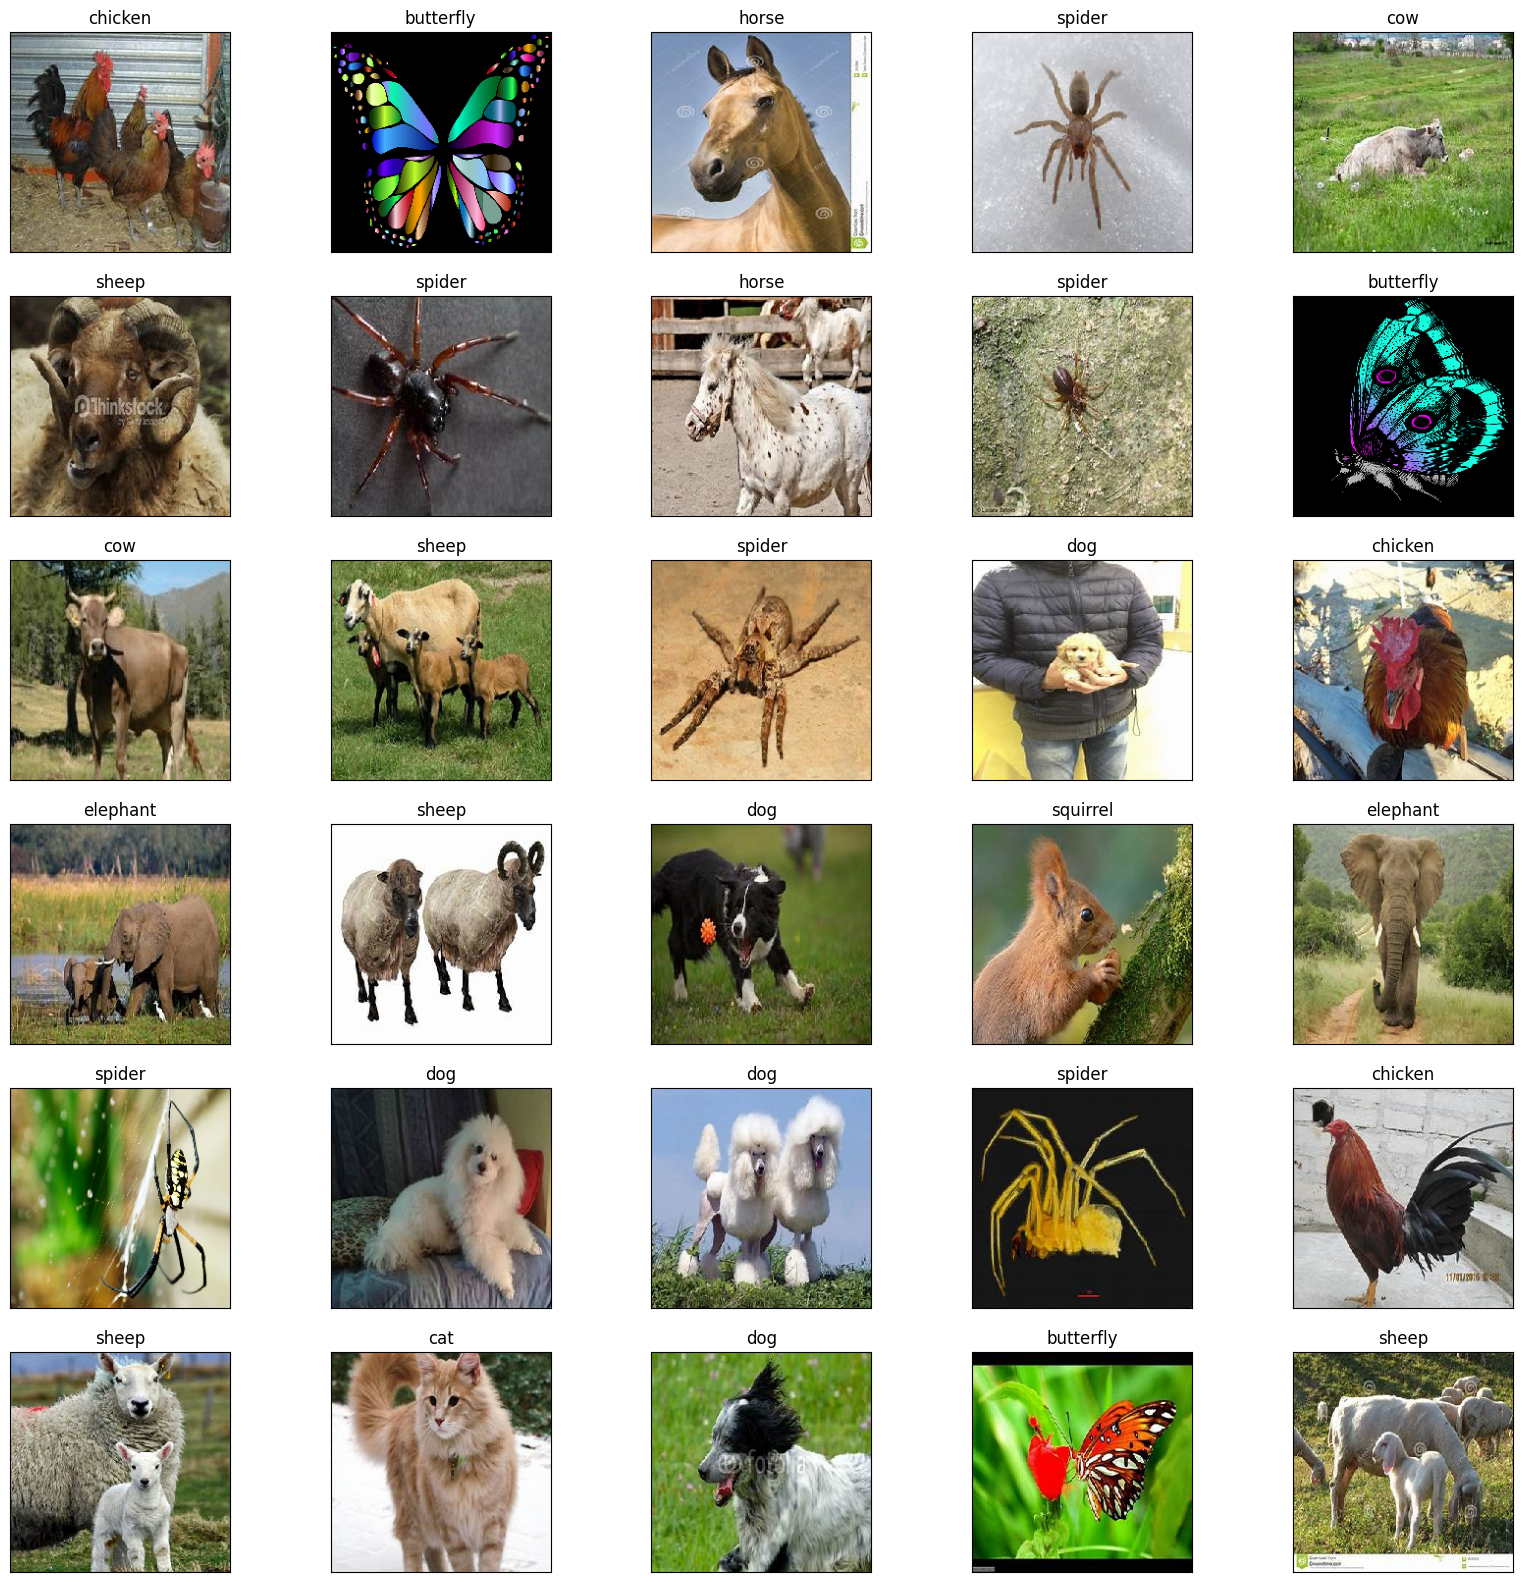

In [24]:
#print out 30 example images after loading in
for images,labels in next(zip(train_data)):
    fig, axs = plt.subplots(6, 5, figsize=(20,20))
    for i, ax in enumerate(fig.axes):
        ax.imshow(images[i])
        #remove tick marks
        ax.set_title(eng_reverse_class[np.argmax(labels[i])])
        ax.set(xticks=[], yticks=[])

We can see that the images are all the same size now that they have been resized to 224x224 pixels. 

# Modeling
We will now create and fit our models. 

For all models, we will allow for early stopping if the validation loss is not decreasing. 

In [26]:
#create function to create CNN models
def createCNN(n = 1,kernel_size = (3,3), strides = 1, num_filters = 32, filt_mult = 1, bn = False, drop = False,
              pool_size = (2,2), dropout_c = 0.2, input_shape = (img_size, img_size, 3)):
    '''
    n = number of layers of [conv2d*3, maxpool]
    kernel_size = size of filter, default 3x3 filter
    strides = stride for conv2d layers
    num_filters = number of filters in Conv2d layer
    filt_mult = multiplicative increase for filter number in later layers if n >1
    bn is batch normalization, if True, batch normalization after every conv2d
    drop is for dropout, if True adds dropout to end of each layer
    pool_size = window size to take the maximum, default is 2x2
    dropout_c = dropout rate for convultional layers, float between 0 to 1
    '''
    #initialize model
    model = Sequential()
    
    #Add n sets of layers to model
    for i in range(n):
        #add conv2d layer
        model.add(Conv2D(num_filters, kernel_size, strides = strides, activation = 'relu', input_shape = input_shape))
        #if bath normalization = True, add layer for it
        if bn:
            model.add(BatchNormalization())
        model.add(Conv2D(num_filters, kernel_size,strides = strides, activation = 'relu'))
        if bn:
            model.add(BatchNormalization())
        model.add(Conv2D(num_filters, kernel_size, strides = strides,activation = 'relu'))
        if bn:
            model.add(BatchNormalization())
            
        #add max pooling layer
        model.add(MaxPooling2D(pool_size = pool_size)) 
        #if dropout is True, add layer for it
        if drop:
            model.add(Dropout(dropout_c))
        
        #update the number of filters for the next set of layers
        num_filters = num_filters * filt_mult
    
    #add classifying layers to the end of model
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    #use 10 and softmax since we have 10 classes
    model.add(Dense(10, activation = "softmax"))
    
    #compile the model with Adam optimizer
    model.compile(Adam(0.00001), loss = "categorical_crossentropy", metrics=["accuracy"])
    #return the model
    return model

In [131]:
#create function to create graphs of accuracy/loss
#for use later on
def modelGraphs(model, model_num, metrics):
    '''
    model = the model to create the graphs based on
    model_num: the index for the model in the notebook. The index
            in the model_acc variable
    metrics = the metrics to plot in graphs
    '''
    model_options = [model1_history,model2_history,model3_history,model4_history]
    #Loop through each metric to make plot
    for metric in metrics:
        #make val_metric
        val_metric = "val_" + metric
        #plot metric
        #plt.plot(np.arange(1,len(model.history.history[metric]) + 1),model.history.history[metric])
        plt.plot(np.arange(1,len(model_options[model_num][metric]) + 1),model_options[model_num][metric])
        #plot validation data metric
        #plt.plot(np.arange(1,len(model.history.history[val_metric]) + 1),model.history.history[val_metric])
        plt.plot(np.arange(1,len(model_options[model_num][val_metric]) + 1),model_options[model_num][val_metric])
        
        #add title, axes labels and legend
        title_options = ['Base Model', 'Extended Model', 'VGG16 Model', 'VGG16 Model with VGG16 Preprocessing']
        plt.title(title_options[model_num] + ": Epoch vs " + metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch Number')
        plt.legend(['Train', 'Validate'], loc='best')
        plt.show();

In [28]:
#Create base model of only 1 layer with a stride of 2 and show summary
model1 = createCNN(n = 1,strides = 2)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 111, 111, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 512)               2769408   
                                                        

In [66]:
#checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",
#                             save_best_only = True,verbose=1)
epochs = 25

#early stopping if model.fit stops improving model performance
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 2, verbose = 1, restore_best_weights=True)
#reduce lr if model not improving
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, 
                                            factor=0.2, min_lr=0.00000001)

In [30]:
#fit the model to the data
model1.fit(train_data,validation_data= val_data,epochs=epochs,
           callbacks=[earlystopping])

Epoch 1/25
524/524 [==============================] - 66s 106ms/step - loss: 2.4314 - accuracy: 0.1845 - val_loss: 2.0906 - val_accuracy: 0.2810
Epoch 2/25
524/524 [==============================] - 64s 122ms/step - loss: 2.0633 - accuracy: 0.2871 - val_loss: 1.8314 - val_accuracy: 0.3711
Epoch 3/25
524/524 [==============================] - 65s 124ms/step - loss: 1.8765 - accuracy: 0.3556 - val_loss: 1.7326 - val_accuracy: 0.4152
Epoch 4/25
524/524 [==============================] - 54s 104ms/step - loss: 1.7754 - accuracy: 0.3902 - val_loss: 1.6864 - val_accuracy: 0.4257
Epoch 5/25
524/524 [==============================] - 55s 105ms/step - loss: 1.7012 - accuracy: 0.4191 - val_loss: 1.6705 - val_accuracy: 0.4441
Epoch 6/25
524/524 [==============================] - 54s 104ms/step - loss: 1.6483 - accuracy: 0.4352 - val_loss: 1.6368 - val_accuracy: 0.4365
Epoch 7/25
524/524 [==============================] - 55s 105ms/step - loss: 1.5950 - accuracy: 0.4594 - val_loss: 1.5760 - val_ac

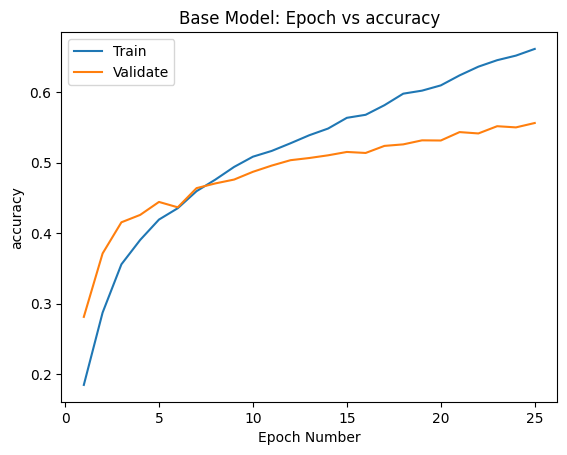

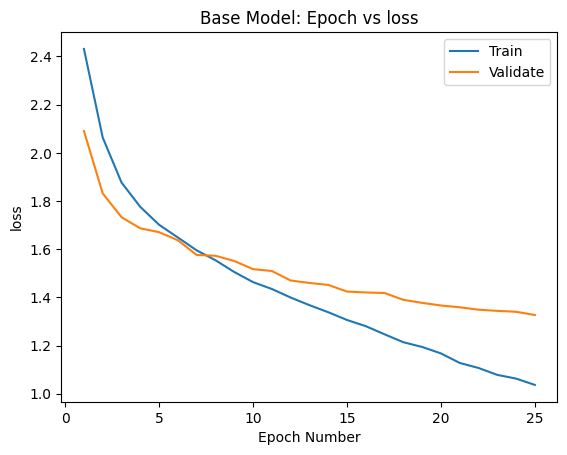

In [31]:
#save history to variable
model1_history = pd.DataFrame(data = model1.history.history)
#plot accuracy and loss vs epoch
modelGraphs(model1, 0, ['accuracy','loss'])

In [32]:
#Create model with 3 repeating layers of conv and maxpool, with batchnormalization and dropout
model2 = createCNN(n = 3,bn = True, drop = False)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 220, 220, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 218, 218, 32)      9248      
                                                                 
 batch_normalization_3 (Batc  (None, 218, 218, 32)    

In [33]:
#fit model
model2.fit(train_data,validation_data= val_data,epochs=epochs,
          callbacks=[earlystopping])

Epoch 1/25
524/524 [==============================] - 75s 123ms/step - loss: 2.7042 - accuracy: 0.2529 - val_loss: 1.9682 - val_accuracy: 0.3527
Epoch 2/25
524/524 [==============================] - 63s 120ms/step - loss: 2.1505 - accuracy: 0.3586 - val_loss: 1.7789 - val_accuracy: 0.4277
Epoch 3/25
524/524 [==============================] - 62s 119ms/step - loss: 1.9332 - accuracy: 0.4047 - val_loss: 1.6540 - val_accuracy: 0.4692
Epoch 4/25
524/524 [==============================] - 63s 120ms/step - loss: 1.7631 - accuracy: 0.4514 - val_loss: 1.6052 - val_accuracy: 0.4928
Epoch 5/25
524/524 [==============================] - 63s 121ms/step - loss: 1.6440 - accuracy: 0.4827 - val_loss: 1.5907 - val_accuracy: 0.4964
Epoch 6/25
524/524 [==============================] - 62s 118ms/step - loss: 1.5490 - accuracy: 0.5054 - val_loss: 1.5381 - val_accuracy: 0.5112
Epoch 7/25
524/524 [==============================] - 62s 119ms/step - loss: 1.4221 - accuracy: 0.5364 - val_loss: 1.5372 - val_ac

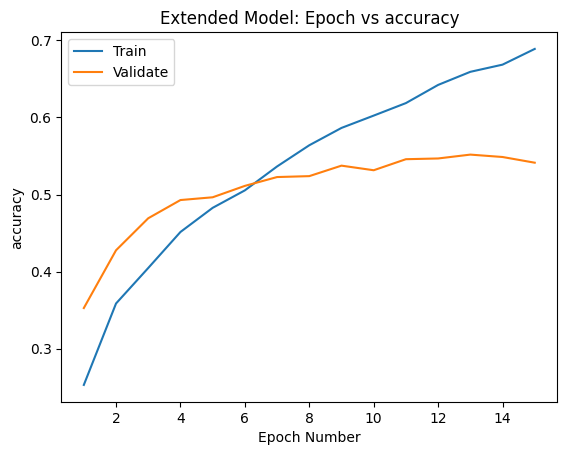

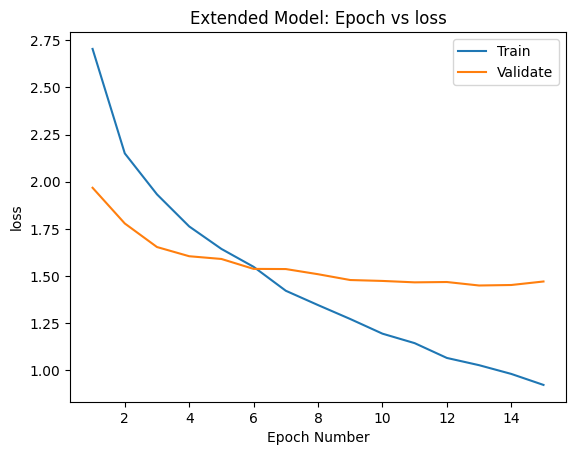

In [34]:
#save history to variable
model2_history = pd.DataFrame(data = model2.history.history)
#plot accuracy and loss vs epoch
modelGraphs(model2, 1, ['accuracy','loss'])

In [35]:
#use the VGG16 model with its weights
base_model3 = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

#add on a classification to the end
last = base_model3.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(10, activation='softmax')(x)
model3 = tf.keras.Model(inputs=base_model3.input, outputs=x)

#compile model
model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])
model3.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [36]:
history = model3.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=[earlystopping])

Epoch 1/25
524/524 [==============================] - 139s 244ms/step - loss: 1.5104 - accuracy: 0.7028 - val_loss: 0.4994 - val_accuracy: 0.8429
Epoch 2/25
524/524 [==============================] - 123s 234ms/step - loss: 1.0489 - accuracy: 0.8684 - val_loss: 0.3965 - val_accuracy: 0.8749
Epoch 3/25
524/524 [==============================] - 122s 233ms/step - loss: 0.9903 - accuracy: 0.9084 - val_loss: 0.3358 - val_accuracy: 0.8902
Epoch 4/25
524/524 [==============================] - 122s 232ms/step - loss: 0.8471 - accuracy: 0.9301 - val_loss: 0.2985 - val_accuracy: 0.9035
Epoch 5/25
524/524 [==============================] - 122s 232ms/step - loss: 0.7838 - accuracy: 0.9455 - val_loss: 0.2829 - val_accuracy: 0.9088
Epoch 6/25
524/524 [==============================] - 122s 233ms/step - loss: 0.5385 - accuracy: 0.9554 - val_loss: 0.3048 - val_accuracy: 0.9052
Epoch 7/25
524/524 [==============================] - 122s 233ms/step - loss: 0.8141 - accuracy: 0.9647 - val_loss: 0.2807 -

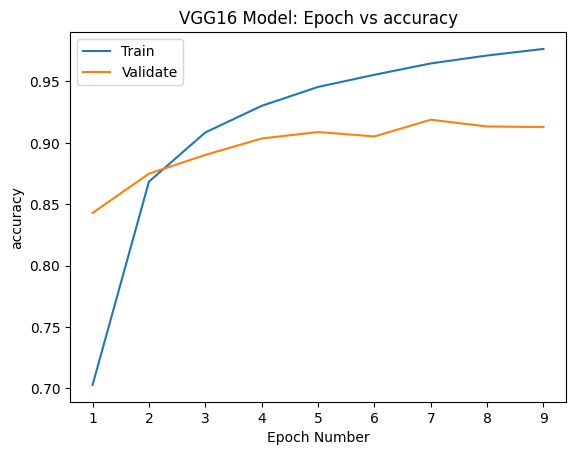

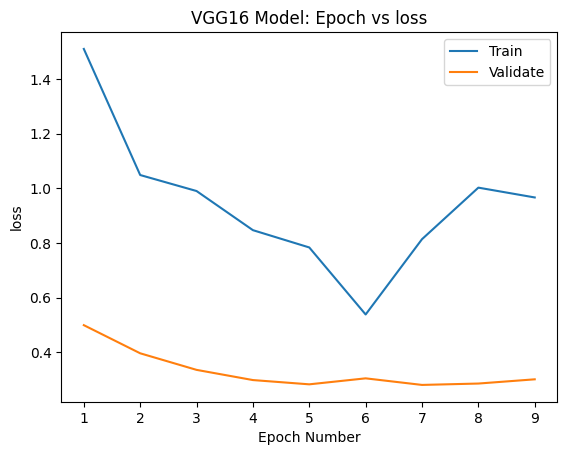

In [132]:
#save history to variable
model3_history = pd.DataFrame(data = history.history)
#plot accuracy and loss vs epoch
modelGraphs(model3, 2, ['accuracy','loss'])

We need to create datasets to be used for the model with its own preprocessing steps. We will create new input data with no preprocessing (except resizing the images).

In [91]:
# make datasets again with no preprocessing
# and split data into training and validation sets
datagen_nopre = ImageDataGenerator(validation_split=0.2)

In [92]:
# generate training data
train_data_nopre = datagen_nopre.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="categorical",
    target_size=(img_size,img_size),
    subset='training')

val_data_nopre = datagen_nopre.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="categorical",
    target_size=(img_size,img_size),
    subset='validation')

#genrate test data that is not shuffled 
#for the model to use to make predictions on
datagen_nopre2 = ImageDataGenerator()
test_data_nopre = datagen_nopre2.flow_from_dataframe(
    dataframe=df_test,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=batch_size,
    seed=rnd_seed,
    class_mode="categorical",
    target_size=(img_size,img_size),
    shuffle=False)

Found 16755 validated image filenames belonging to 10 classes.
Found 4188 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [67]:
#set input and use VGG16 model
i = tf.keras.layers.Input([img_size, img_size, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = vgg16.preprocess_input(x)
base_model4 = VGG16(include_top = False,
                   weights = 'imagenet')

#add on classification to end
x = base_model4(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512,'relu')(x)
x = Dense(10, activation='softmax')(x)
model4 = tf.keras.Model(inputs=i, outputs=x)

#compile model
model4.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.000005),
              metrics=['accuracy'])
model4.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_8 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_9   (None, 512)              0   

In [68]:
history4 = model4.fit(train_data_nopre,
                    epochs=epochs,
                    validation_data=val_data_nopre,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/25
524/524 [==============================] - 127s 231ms/step - loss: 79.2531 - accuracy: 0.4244 - val_loss: 1.1423 - val_accuracy: 0.6404 - lr: 5.0000e-06
Epoch 2/25
524/524 [==============================] - 122s 232ms/step - loss: 35.2503 - accuracy: 0.7440 - val_loss: 0.6687 - val_accuracy: 0.7908 - lr: 5.0000e-06
Epoch 3/25
524/524 [==============================] - 122s 232ms/step - loss: 25.8953 - accuracy: 0.8511 - val_loss: 0.5576 - val_accuracy: 0.8312 - lr: 5.0000e-06
Epoch 4/25
524/524 [==============================] - 122s 233ms/step - loss: 29.5643 - accuracy: 0.8814 - val_loss: 0.5368 - val_accuracy: 0.8348 - lr: 5.0000e-06
Epoch 5/25
524/524 [==============================] - 121s 231ms/step - loss: 34.5922 - accuracy: 0.8850 - val_loss: 0.5328 - val_accuracy: 0.8329 - lr: 5.0000e-06
Epoch 6/25
524/524 [==============================] - 122s 233ms/step - loss: 31.1407 - accuracy: 0.9003 - val_loss: 0.4355 - val_accuracy: 0.8629 - lr: 5.0000e-06
Epoch 7/25
524/5

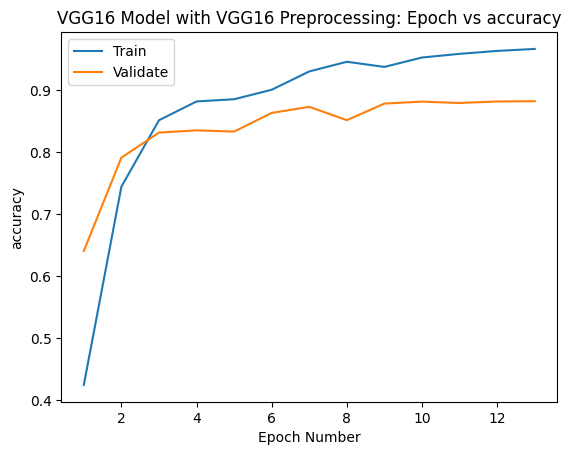

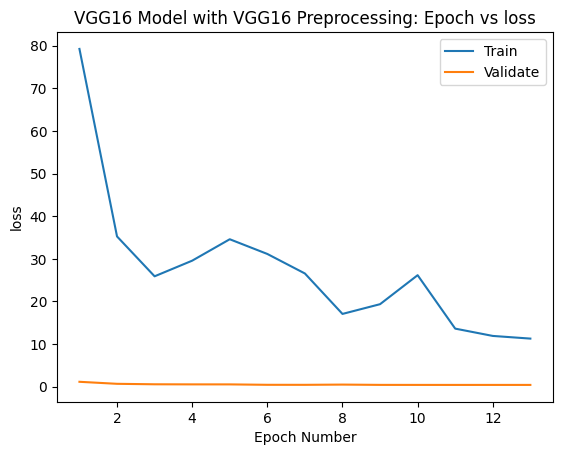

In [134]:
#save history to variable
model4_history = pd.DataFrame(data = history4.history)
#plot accuracy and loss vs epoch
modelGraphs(model4, 3, ['accuracy','loss'])

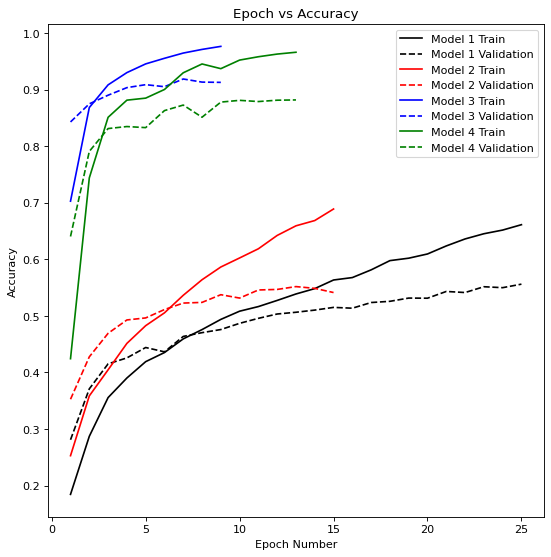

In [70]:
#plot all accuracies on one plot
val_metric = "val_accuracy"
x_epoch1 = np.arange(1,len(model1_history['accuracy']) + 1)
x_epoch2 = np.arange(1,len(model2_history['accuracy']) + 1)
x_epoch3 = np.arange(1,len(model3_history['accuracy']) + 1)
x_epoch4 = np.arange(1,len(model4_history['accuracy']) + 1)
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(x_epoch1,model1_history['accuracy'], 'k-',x_epoch1,model1_history['val_accuracy'], 'k--')
plt.plot(x_epoch2,model2_history['accuracy'], 'r-',x_epoch2,model2_history['val_accuracy'], 'r--')
plt.plot(x_epoch3,model3_history['accuracy'], 'b-',x_epoch3,model3_history['val_accuracy'], 'b--')
plt.plot(x_epoch4,model4_history['accuracy'], 'g-',x_epoch4,model4_history['val_accuracy'], 'g--')

#add title, axes labels and legend
plt.title("Epoch vs Accuracy")
plt.ylabel("Accuracy")
plt.xlabel('Epoch Number')
plt.legend(['Model 1 Train', 'Model 1 Validation','Model 2 Train', 'Model 2 Validation',
            'Model 3 Train', 'Model 3 Validation','Model 4 Train', 'Model 4 Validation'], loc='best')
plt.show();

The above accuracy charts show that the basic CNN structures are much worse (model 1 and 2) than the pre-trained VGG16 models (models 3 and 4). I'm surprised how much better they were, but not that they were better. I expected them to be better than the basic structure because they are deeper, use more filters, are more complex, and pre-trained on the imagenet dataset. These pre-trained weights should give the models a better starting point than the basic structures starting from scratch. The additional complexity of the model should allow it to do a better job fitting to the training data.

Model 3 is the pre-trained VGG16 that uses the basic preprocessing we did (resizing and scaling the pixel values to between 0 and 1), and does not use the vgg16 preprocessing. This is surprising to me because I thought the vgg16 preprocessing would have led to better results. 

For each model, multiple learning rates were trialed, and the best result was then used to show here.

# Results


In [95]:
def predict_and_save_results(model, model_num):
    '''
    This function will predict for the train data and test data and then save the results
    model = model to predict from
    model_num = the model number
    '''
    if model_num == 3:
        #evaluate the model for accuracies for train, validation, and test sets
        train_loss, train_acc = model.evaluate(train_data_nopre)
        val_loss, v_acc = model.evaluate(val_data_nopre)
        test_loss, te_acc = model.evaluate(test_data_nopre)
        #predict the test data to show confusion matrix
        y_test = model.predict(test_data_nopre, verbose=1)
    else:
        #evaluate the model for accuracies for train, validation, and test sets
        train_loss, train_acc = model.evaluate(train_data)
        val_loss, v_acc = model.evaluate(val_data)
        test_loss, te_acc = model.evaluate(test_data)
        #predict the test data to show confusion matrix
        y_test = model.predict(test_data, verbose=1)

    # Get the actual labels
    ya_test = test_data.classes
    
    ##determine predicted class by getting index of max value
    yp_test = np.argmax(y_test,axis=1)
    
    #calculate metrics and save to variable to show in results table
    acc[model_num] = train_acc
    val_acc[model_num] = v_acc
    test_acc[model_num] = te_acc

    #make confusion matrix
    ConfusionMatrixDisplay.from_predictions(ya_test,yp_test,xticks_rotation='vertical')
    plt.show
    

In [72]:
#initialize variables for results table
acc = np.zeros(4)
val_acc = np.zeros(4)
test_acc = np.zeros(4)

164/164 [==============================] - 13s 82ms/step


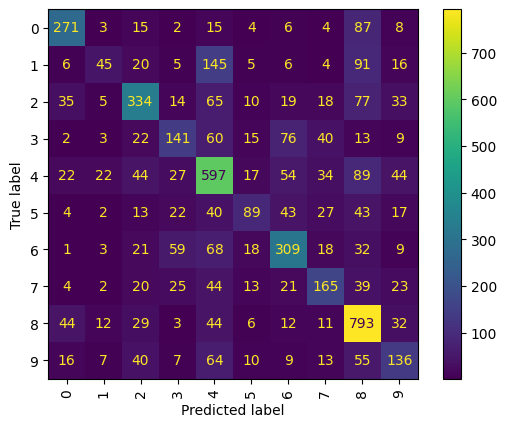

In [87]:
#use function to predict output values
submission1 = predict_and_save_results(model1, 0)

Model 1 does not have great results. The validation and test accuracies are ~55%, and the confusion matrix shows a lot of misidentified images with no immediately noticeable pattern. The loss and accuracies are shown in this order: training, validation, test.

164/164 [==============================] - 14s 83ms/step


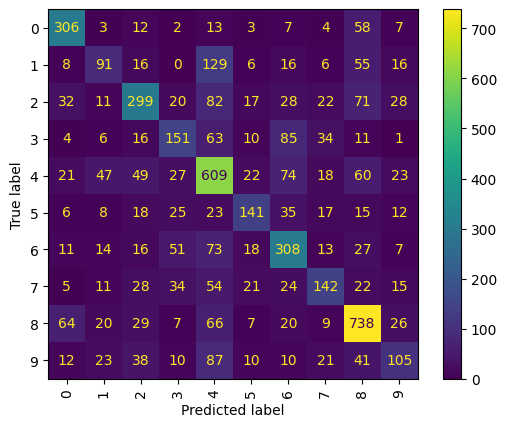

In [88]:
#use function to predict output values
submission2 = predict_and_save_results(model2, 1)

Model 2 gives similar results to model 1, which is not great.

164/164 [==============================] - 15s 93ms/step


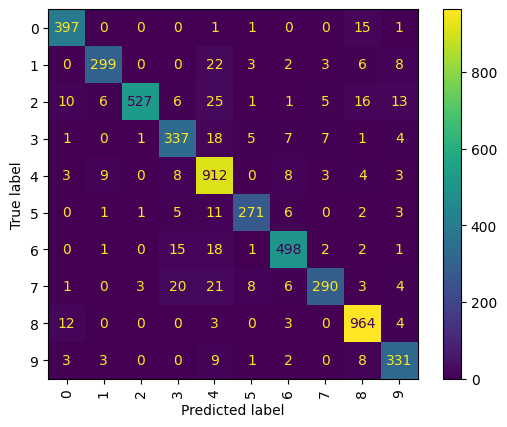

In [89]:
#use function to predict output values
submission3 = predict_and_save_results(model3, 2)

Model 3 provides great results! The test accuracy is ~92% (the third one shown). There are a lot of predicted "4's" that are incorrect compared to other labels. However, it does not seem like an abnormally high amount to raise concern.

164/164 [==============================] - 15s 91ms/step


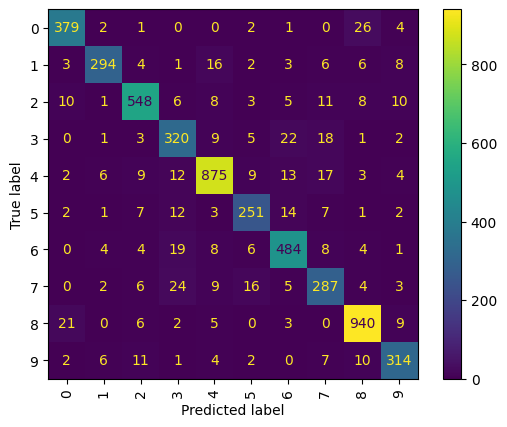

In [96]:
#use function to predict output values
submission4 = predict_and_save_results(model4, 3)

In [98]:
#Set model names variables and number of parameters for results table
mod_names = ['Base Model', 'Extended Model', 'VGG16 Model','VGG16 with VGG16 preprocessing']


In [99]:
#make results table
results = pd.DataFrame(list(zip(mod_names,acc,val_acc,test_acc)),
                       columns = ['Model','Training Accuracy',
                                  'Validation Accuracy', 'Testing Accuracy'])
results

Model  Training Accuracy  Validation Accuracy  \
0                      Base Model           0.739958             0.556113   
1                  Extended Model           0.828051             0.551815   
2                     VGG16 Model           0.977857             0.918816   
3  VGG16 with VGG16 preprocessing           0.962101             0.878940   

   Testing Accuracy  
0          0.550038  
1          0.551948  
2          0.921696  
3          0.896104

The best model is the VGG16 model with the basic preprocessing of standardizing the pixel values between 0 and 1. It had a test accuracy ~92%. The VGG16 model using VGG16 preprocessing was only slightly worse at ~90% test accuracy. The basic CNN structures were much worse at ~55% test accuracy. All the models show some signs of overfitting with the training accuracy being larger than the validation and testing accuracies. However, the validation metrics are very similar to the training metrics which is a promising sign. More analysis would need to take place to determine why the training results are higher than the others. Could there be an unidentified bias in the training or test sets?

Many hyperparameters were trialed and tuned throughout the process. Batch normalization, dropout, pooling, and number of layers all improved the models. Different variations of these hyperparameters were trialed at an initial stage, but only the 4 models shown in the table were kept for the results table due to time and GPU constraints. More hyperparameters could have been tuned with additional time and capacity. 

We will look at the precision, recall and F1 score of each class for our best model:

In [101]:
#predict for the test images
y_test = model3.predict(test_data, verbose=1)
#determine which class by getting index of max value
yp_test = np.argmax(y_test,axis=1)

# Get the actual labels
ya_test = test_data.classes

print(classification_report(ya_test,yp_test))

164/164 [==============================] - 16s 95ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       415
           1       0.94      0.87      0.90       343
           2       0.99      0.86      0.92       610
           3       0.86      0.88      0.87       381
           4       0.88      0.96      0.92       950
           5       0.93      0.90      0.92       300
           6       0.93      0.93      0.93       538
           7       0.94      0.81      0.87       356
           8       0.94      0.98      0.96       986
           9       0.89      0.93      0.91       357

    accuracy                           0.92      5236
   macro avg       0.92      0.91      0.91      5236
weighted avg       0.92      0.92      0.92      5236



In [102]:
#get class indices and reverse dictionary so can use later
test_reverse_class_ind = {num: let for let, num in test_data.class_indices.items()}

test_reverse_class_ind

{0: 'butterfly',
 1: 'cat',
 2: 'chicken',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'horse',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

The worst f1-scores were for cow and sheep. Looking at the confusion matrix a few cells above, there is no one specific other class they are misidentifed as. Overall I think this model does a good job identifying all the different animals with a minimum f1-score of 0.87!

Let's look at a few of the misidentified images:

In [113]:
#create df for test results
test_result_df = pd.DataFrame()
#make column for filename
test_result_df['filename'] = test_data.filenames
#make column for actual label
test_result_df['actual'] = ya_test
#make column for predicted label
test_result_df['predicted'] = yp_test
#change aactual and predicted labels to the name of the animal from a number
test_result_df['actual'] = test_result_df['actual'].apply(lambda row: test_reverse_class_ind[row])
test_result_df['predicted'] = test_result_df.apply(lambda row: test_reverse_class_ind[row['predicted']],axis=1)
#Make column for if actual matches predicted
test_result_df['Correct'] = test_result_df.apply(lambda row: row['actual'] == row['predicted'],axis=1)
#calculate accuracy, it matches!
print("Accuracy: ", round(sum(test_result_df['Correct']/len(test_result_df)),2))
test_result_df

Accuracy:  0.92


filename     actual  predicted  \
0         cane/OIP-DKmEnHHux5z1gNZQMm7rhgHaFj.jpeg        dog        dog   
1       pecora/OIP-AKLnkpH6ds9Z8nweYcj3PQHaBv.jpeg      sheep        cow   
2     farfalla/OIP-EWTqZHZPtPVEfBnMDFTZngHaEK.jpeg  butterfly  butterfly   
3     farfalla/OIP-cgVnkaB7_2hEJ-7lhGelNgHaFj.jpeg  butterfly  butterfly   
4       pecora/OIP-rcyqXob3zEHEfkKDA-p5RwAAAA.jpeg      sheep      sheep   
...                                            ...        ...        ...   
5231     ragno/OIP-_0YC0pbR0XIolgpTaswWRwHaFj.jpeg     spider     spider   
5232      cane/OIP-MXyipK6U0Jit6RIMB1Gs8gAAAA.jpeg        dog     spider   
5233   cavallo/OIP-Y7KyhD1odFEC5rJ8zPMJHgHaEI.jpeg      horse     spider   
5234      cane/OIP-7_b6BO01yoDYJIA1NQIkPQHaFf.jpeg        dog        cow   
5235      cane/OIP-aUFx6UG7auu2yrLxURcFSQHaF0.jpeg        dog     spider   

      Correct  
0        True  
1       False  
2        True  
3        True  
4        True  
...       ...  
5231     True  
5232    False  
5233    False  
5234    False  
5235    False  

[5236 rows x 4 columns]

In [116]:
#make df for incorrect predictions only, reset df index
wrong_df = test_result_df[test_result_df['Correct'] == False].reset_index(drop=True)
wrong_df.loc[1,'filename']

'farfalla/OIP-BZwUTAz39WQdWBOzKxSfQAHaFj.jpeg'

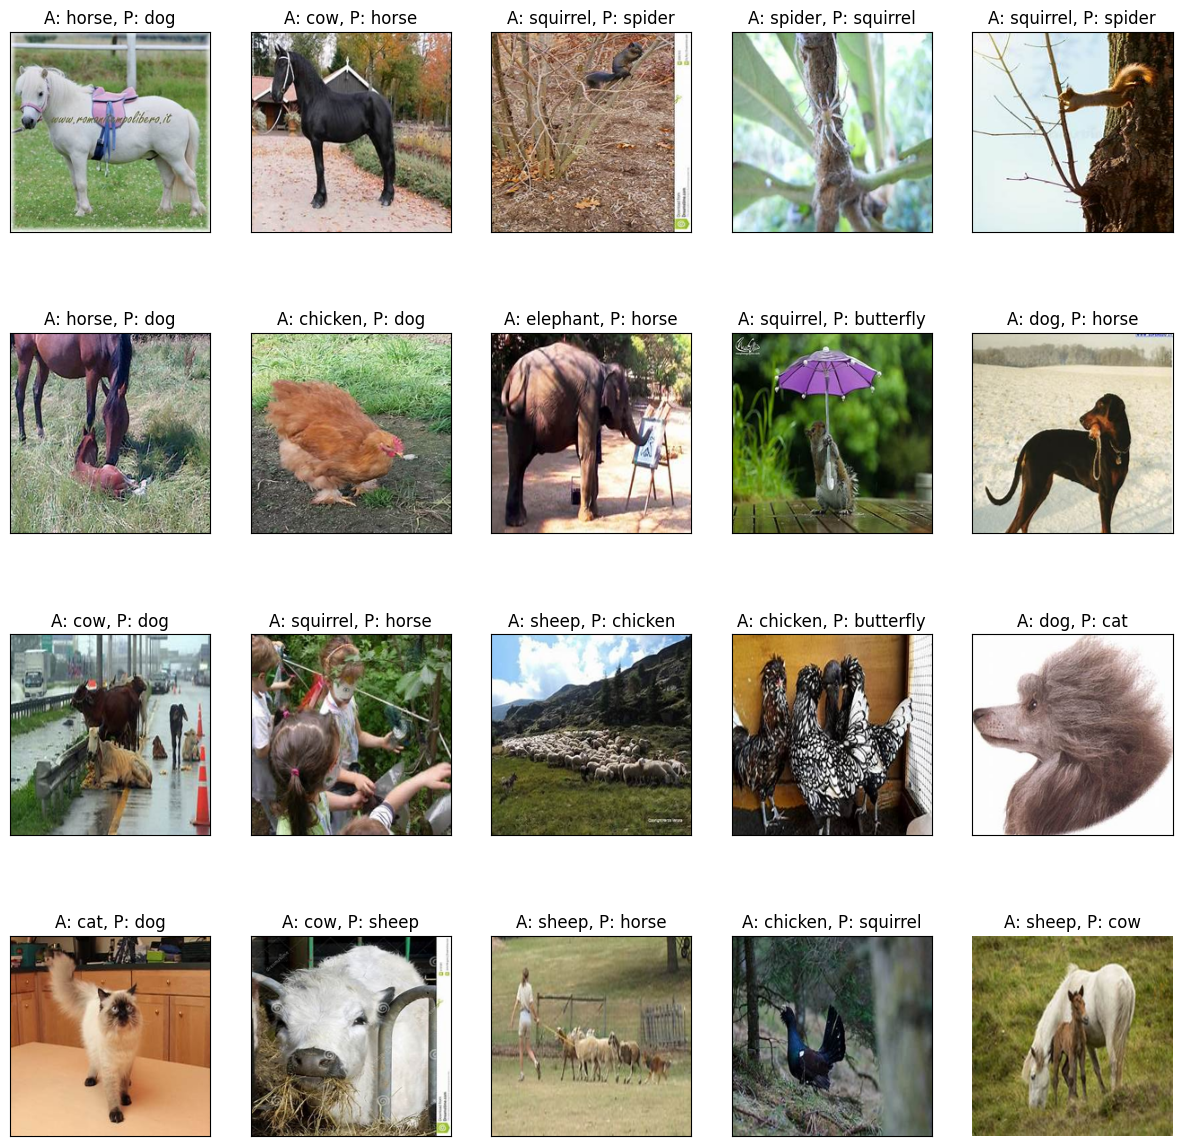

In [128]:
#get number of wrong in test set
N_wrong = len(test_result_df[test_result_df['Correct'] == False])
#creat df of wrong predictions
wrong_df = test_result_df[test_result_df['Correct'] == False].reset_index(drop=True)

#randomly sample 20 numbers
randsamp = np.random.randint(0,N_wrong,20)
#make a subplot
fig, axs = plt.subplots(4, 5, figsize=(15,15))
#iterate of subplots
for i, ax in enumerate(fig.axes): 
    #get image path
    img_path = train_path + '/' + wrong_df.loc[randsamp[i],'filename']
    #open image
    img = Image.open(img_path)
    #show image after resizing
    ax.imshow(img.resize((224, 224)))
    #turn off axis
    plt.axis('off')
    #make the title 0 for no tumor, or 1 for tumer
    ax.set_title("A: " + wrong_df.loc[randsamp[i],'actual'] + ", P: " + wrong_df.loc[randsamp[i],'predicted'])
    #remove tick marks
    ax.set(xticks=[], yticks=[])   

There are a couple of images shown above that seem like they have invalide actual labels. The second image shows a horse, but says it is a cow (and the model predicts horse)! The second image on the third row has 3 little kids and maybe a part of a squirrel? But mostly children, so not very valid. I think this image should be removed from the dataset.

There are also a few that I can understand how the model misinterpreted the image. The first example on the third row shows cows on a road. However, most images of cows probably show them in a field and these cows are clustered together and very skinny. The third image on the bottom row has sheep and a human. However, the picture is pretty blurry and it is challenging for me to make out that they are sheep. 

Overall, I think this shows our model does pretty well! 

# Conclusions
Convolutional neural networks (CNN) are a very useful tool for analyzing images. By using a CNN and our training data set, our best model was able to learn the 10 classes and predict the test data set with 92% accuracy! Those are amazing results for a initial application of CNN. 

CNNs are a powerful tool, but there are also some things that you need to be careful about. They can overfit the data and lead to poor validation/test results. They also take a long time to train. So if you don't know what you are doing, you can waste a lot of time trying to train a model incorrectly. 

There are a few things that could be looked at in the future to improve the model. First, the data includes some erroneous data (incorrect labels on images). After we have a model, we could predict on images, locate the erroneous data and then create new datasets with only accurate labels and images. Second, we took all the images as is and used them (after resizing to a standard size and normalizing the pixel values), but you could create many more images by rotating, mirroring, cropping, or lightening/darkening the images. This would create a much larger dataset and could lead to improved results by having many more examples of each class. Third, the classes are not balanced. We could balance the classes and see what affects it has on our models. Lastly, there are many, many more preprocessing and tuning that could be done. In the future, it would be great to try more of these steps and tunings to see how they affect the models. 

# References
The following notebooks and websites were very useful:

* https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
* https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see
* https://keras.io/api/applications/vgg/#vgg16-function
